# 1-D Heat Transfer solver for an inert solid. 
- Uses Crank-Nicholson method
- Boundary conditions can be chosen to be constant temperature, constant NHF, convection or convection + radiation.
- Back face conditions can be chosen to be insulated or in contact with an aluminium block

$$ A x T^{n+1} = B x T^{n} $$

1. Define material properties
2. Define the geometry
3. Define the inital condition
4. Define matrix A

    For each time step:
    5. Define matrix B
    6. Calculate $ b = B \cdot T^n $
    7. Solve $ T^{n+1} = A^{-1} \cdot b $
    8. Store $ T^{n+1} $
        
        

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import matplotlib as mpl

In [102]:
# Define material properties
PMMA = {"k": 0.0002, # kW/mK [Vermesi_PhD]
        "rho": 1190, # kg/m3 [Vermesi_PhD]
        "c": 1.606,  # kJ/kgK [Vermesi_PhD]
        "emissivity": 1,
        "absortivity":1,
       }

PA6 =  {"k": 1,
        "rho": 1,
        "c": 1,
        "emissivity": 1,
        "absortivity":1,
       }

TIMBER =  {"k": 1,
           "rho": 1,
           "c": 1,
            "emissivity": 1,
            "absortivity":1,
          }

ALUMINIUM =  {"k": 0.167,  # kW/mK [Vermesi_PhD]
              "rho": 2700, # kg/m3 [Vermesi_PhD]
              "c": 0.896,  # kJ/kgK [Vermesi_PhD]
              "m": 0.4,    # kg
              "emissivity": 1,
              "absortivity":1,
             }

In [115]:
# Define sample characteristics

# Sample characteristics
sample_depth0        = 0.025  # meters
space_mesh_points0   = 101    # (-)
duration_experiment0 = 900    # seconds
time_mesh_points0    = 1000   # (-)
sample_material0     = "PMMA" # PMMA, PA6, TIMBER, ALUMINIUM
initial_temperature0 = 20     # C

# Aluminium characteristics (assume lumped capacitance)
sample_depth1        = 0.02                   # meters
sample_material1     = "ALUMINIUM"            # ALUMINIUM
initial_temperature1 = initial_temperature0   # C

In [104]:
# Define the boundary conditions
BC_type      = "const_temp"    # "const_temp", "const_nhf", "convection", "conv_rad"
BC_type_back = "semi_inf"      # "semi-inf" or "al_block"   

if BC_type == "const_temp" and BC_type_back == "semi_inf":
    t_surface   = 200 # C
    # Below these conditions are aggregated and form the argument for the function call
    conditions_for_b = (t_surface, initial_temperature0)
elif BC_type == "const_temp":
    nhf_surface = 20  # kW/m2
else:
    q_inc           = 25 + np.zeros(time_mesh_points0)  # np.array(time_mesh_points)
    temperature_gas = 20 + np.zeros(time_mesh_points0)  # np.array(time_mesh_points)

In [105]:
# Some plotting characteristics

mpl.rc('font', size=18)
mpl.rc('font', family='Arial')
figure_size = (16,12)
x_lim_inicond = [0, sample_depth0]
y_lim_inicond = [0,initial_temperature0 + 25]
x_lim_other   = [0,sample_depth0]
y_lim_other   = [0,550]

In [106]:
# Define the mesh and initial condition
def define_mesh_icond(length_meters, length_divisions, time_domain, time_divisions, material, initial_temperature):
    """"
    Defines the grid, chooses material, initializes matrices.
    
    Returns space and time grids, material properties, T, Tn and sigma
    """

    dx = length_meters/(length_divisions - 1)
    dt = time_domain/(time_divisions - 1)
    
    x_grid = np.array([i*dx for i in range(length_divisions)])
    t_grid = np.array([n*dt for n in range(time_divisions)])  
    
    material = material.upper()
    if material == "PMMA":
        material = PMMA
    elif material == "PA6":
        material = PA6    
    elif material == "TIMBER":
        material = TIMBER
    material["alpha"] = material["k"]/(material["rho"]*material["c"])
    
    sigma = material["alpha"]*dt/(2*dx**2)
    
    T = np.zeros(length_divisions) + initial_temperature
    Tn = np.empty_like(T)
        
    return (x_grid, t_grid,dx,dt,material, T, Tn, sigma)

In [107]:
def plot_tempgrad(T,x_grid,figure_size,x_lim,y_lim, title, save_format):
    """
    Plots temperature gradient at a given time
    
    Save format = None for no saving
    """

    fig,ax = plt.subplots(figsize = figure_size)
    ax.plot(x_grid,T, linewidth = 2.5)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.set_xlabel("Depth [m]")
    ax.set_ylabel("Temperature [C]")
    ax.set_title(title)
    if save_format == None:
        pass
    else:
        fig.savefig(title + save_format,dpi = 300)
    
    return None

In [121]:
def tridiag_matrix(sigma, length_divisions, BC_type):
    """
    Creates tridiagonal matrix A
    
    BC_type = (BC_type, BC_type_back)
    
    BC_type: "const_temp", "const_nhf", "convection", "conv_rad"
    BC_type_back: "semi_inf" or "al_block"
    """
    
    A = np.diagflat([-sigma for i in range(length_divisions-1)], -1) +\
        np.diagflat([1+2*sigma for i in range(length_divisions)]) +\
        np.diagflat([-sigma for i in range(length_divisions-1)], 1)
    
    # Boundary conditions
    if BC_type[0] == "const_temp" and BC_type[1] == "semi-inf":
        A[0,0] = 1
        A[0,1] = 0
        A[-2,-1] = 0
        A[-1,-1] = 0
    
    return A

In [129]:
def vector_b(sigma, length_divisions, T,BC_type, conditions_for_b):
    """
    Calculates vector at the right hand side of the algebraic equation
    
    BC_type = (BC_type, BC_type_back)
    
    BC_type: "const_temp", "const_nhf", "convection", "conv_rad"
    BC_type_back: "semi_inf" or "al_block"
    """
    
    B = np.diagflat([sigma for i in range(length_divisions-1)],-1) +\
        np.diagflat([1-2*sigma for i in range(length_divisions)]) +\
        np.diagflat([sigma for i in range(length_divisions-1)], 1)
    
   # Calculate vector b
    b = B.dot(T)
    
    # Apply surface boundary conditions
    if BC_type[0] == "const_temp":
        b[0] = conditions_for_b[0]
        
    if BC_type[1] == "semi_inf":
        b[-1] = conditions_for_b[1]
            
    return b

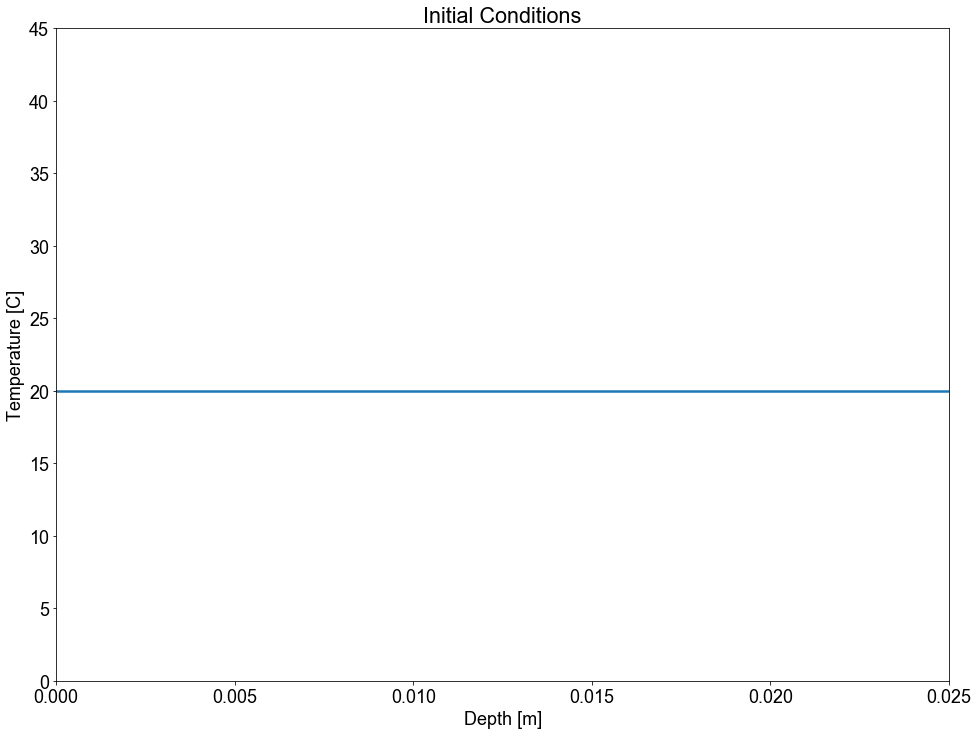

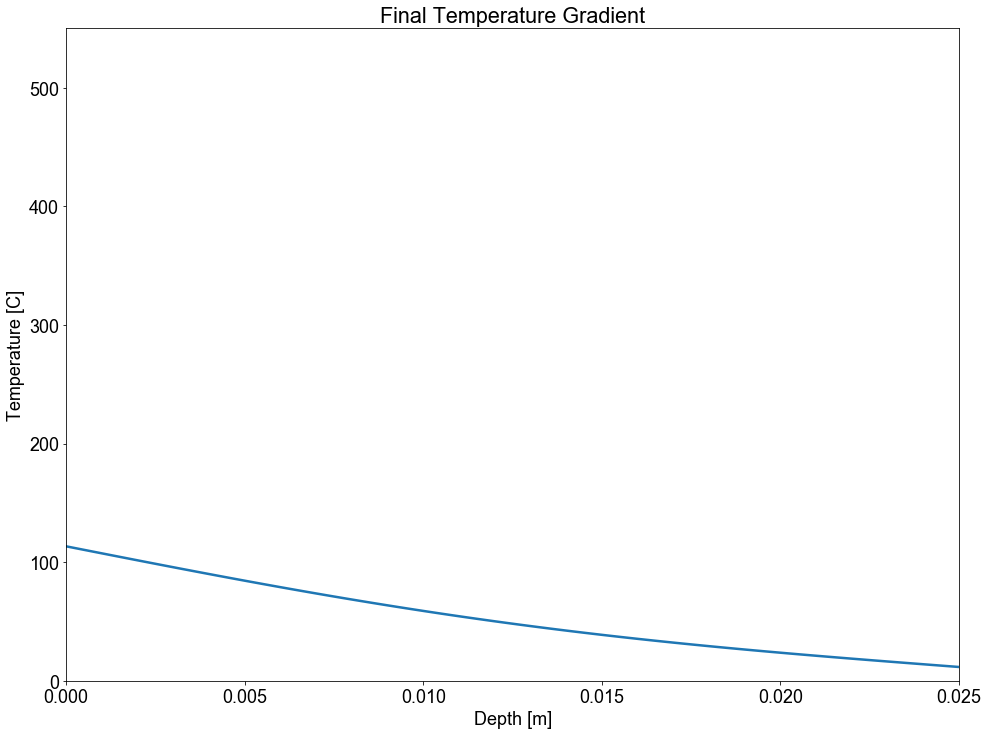

In [130]:
# MAIN

def solve_and_plot():
    # Mesh and initial condition
    x_grid, t_grid, dx, dt, material, T, Tn, sigma = define_mesh_icond(sample_depth0,space_mesh_points0,
                                                                       duration_experiment0,time_mesh_points0,
                                                                   sample_material0,initial_temperature0)
    # Plot initial condition
    plot_tempgrad(T,x_grid,figure_size,x_lim_inicond, y_lim_inicond, "Initial Conditions", None)
    
    # Create tri-diagonal matrix A
    A = tridiag_matrix(sigma,space_mesh_points0,(BC_type, BC_type_back))
    
    # Stores all T values (for all x and t) in a list
    Temperature = []
    Temperature.append(T)
    
    # Iterate over the time domain
    for _ in range(duration_experiment0):
        # Calculate vector b (Create matrix B and multiply by T)
        b = vector_b(sigma, space_mesh_points0, T,(BC_type,BC_type_back), conditions_for_b)
    
        # Solve for T^{n+1}
        Tn = np.linalg.solve(A,b)
        T = Tn.copy()
        Temperature.append(T)
    
    # Plot final temperature gradient
    plot_tempgrad(T,x_grid,figure_size,x_lim_other, y_lim_other, "Final Temperature Gradient", None)
    return Temperature

# Call the main function
Temperature_history = solve_and_plot()

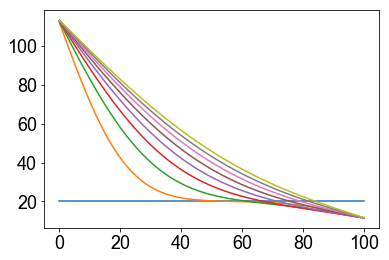

In [131]:
for i in range(0,900,100):
    plt.plot(Temperature_history[i])

In [124]:
Temperature_history[800]

array([113.33871243, 111.77726424, 110.21664973, 108.6574508 ,
       107.10024744, 105.54561699, 103.99413332, 102.44636612,
       100.90288013,  99.36423435,  97.83098139,  96.30366669,
        94.78282783,  93.26899384,  91.76268455,  90.26440991,
        88.77466937,  87.29395125,  85.82273218,  84.36147653,
        82.91063582,  81.47064826,  80.04193821,  78.62491576,
        77.21997624,  75.82749986,  74.44785126,  73.08137924,
        71.72841635,  70.38927865,  69.06426541,  67.75365888,
        66.4577241 ,  65.17670869,  63.91084271,  62.66033856,
        61.42539084,  60.20617633,  59.00285395,  57.81556471,
        56.64443177,  55.48956047,  54.3510384 ,  53.22893547,
        52.12330409,  51.03417924,  49.96157869,  48.90550313,
        47.86593644,  46.84284585,  45.83618223,  44.84588035,
        43.87185909,  42.91402184,  41.9722567 ,  41.04643688,
        40.13642096,  39.2420533 ,  38.36316433,  37.49957094,
        36.65107686,  35.81747298,  34.99853778,  34.19